In [280]:
!python --version

Python 3.12.4


In [1]:
import pandas as pd
import json
import re
import numpy as np
import itertools

# 1. Preliminary Online Screening Questionnaires

#### Survey or Test/BIDS TSV Name
- Alcohol Use Disorders Identification Test (AUDIT)	audit.tsv
- Demographics	demographics.tsv
- Drug Use Questionnaire	drug_use.tsv
- Edinburgh Handedness Inventory (EHI)	ehi.tsv
- Health History Questions	health_history_questions.tsv
- Health Rating	health_rating.tsv
- Mental Health Questions	mental_health_questions.tsv
- World Health Organization Disability Assessment Schedule 2.0 (WHODAS 2.0)	whodas.tsv

#### _____________________________________________________________________________________________________________

### Alcohol Use Disorders Identification Test (AUDIT) audit.tsv

##### We are going to combine the score from all the columns to calculate the audit test sccore as according to https://nida.nih.gov/sites/default/files/files/AUDIT. Then we will disregards the existing column and have one column with 3 different categories:

###### 0: low-risk (score 1 to 7)
###### 1: hazardous or harmful alcohol consumption (score 8-14) 
###### 2: alcohol dependence moderate-severe alcohol use disorder (score >= 15)

##### A score of 1 to 7 suggests low-risk consumption according to World Health Organization (WHO) guidelines. Scores from 8 to 14 suggest hazardous or harmful alcohol consumption and a score of 15 or more indicates the likelihood of alcohol dependence (moderate-severe alcohol use disorder).



In [2]:
audit = pd.read_csv('audit.tsv', sep='\t')
mapping_dict = {col: col.split(',')[0] for col in audit.columns}
audit.rename(columns=mapping_dict, inplace=True)
columns_to_sum = audit.columns.difference(['participant_id'])
audit['Audit_Category'] = audit[columns_to_sum].sum(axis=1)
print('Any missing values?:',audit.isna().any().any(),'\n')
audit['Audit_Category'] = audit['Audit_Category'].apply(lambda x: 0 if x >= 0 and x <= 7 else (1 if x >= 8 and x <= 14 else 3))
print('How many in each category?:')
print(audit['Audit_Category'].value_counts())
audit = audit[['participant_id','Audit_Category']]

Any missing values?: False 

How many in each category?:
Audit_Category
0    947
1     79
3     42
Name: count, dtype: int64


#### _______________________________________________________________________________________________________________
### Drug Use Questionnaire	drug_use.tsv

##### According to https://www.psychiatry.org/getmedia/cf5e60dd-6452-4b1b-a42f-40a7d46b410b/APA-DSM5TR-Level2SubstanceUseAdult all columns should be intepreted individually. 

In [3]:
drug_use = pd.read_csv('drug_use.tsv', sep='\t')

In [4]:
# cat drug_use.json

#### ____________________________________________________________________________________________________________
### health_history_questions.tsv 
##### We first look into missing value. Columns with to many missing values will be dropped. threshold set to 70%. 
##### Additionally following column will be dropped:
###### "PREGNANT": "Description": "Pregnant or trying to get pregnant"


##### All column beginning with "nimh" will be formed from 6 categories: 
###### "0": "You",
######          "1": "Grandparents",
######            "2": "Father",
######            "3": "Mother",
######            "4": "Siblings",
######            "5": "Children",
######            "6": "None"

##### To 3 categories:

###### 0: None
###### 1: yes occurence within family

In [5]:
health_history = pd.read_csv('health_history_questions.tsv', sep='\t')
health_history.drop(columns=['nimh_rv_clinhx_02, current_medication','PREGNANT', 'nimh_rv_clinhx_01','nimh_rv_clinhx_01_2','nimh_rv_clinhx_01_3','nimh_rv_clinhx_01_4','nimh_rv_clinhx_01_5',], inplace=True)
health_history.replace(-999, np.nan, inplace=True)
na_percentages = health_history.isna().mean() * 100
columns_to_drop = na_percentages[na_percentages > 70].index.tolist()
health_history.drop(columns=columns_to_drop, inplace=True)
columns_to_transform = [col for col in health_history.columns if col.startswith('nimh') or col.startswith('CLIN')]
health_history[columns_to_transform] = health_history[columns_to_transform].map(lambda x: 1 if x in [0, 1, 2, 3, 4, 5] else (0 if x == 6 else x))

#### ____________________________________________________________________________________________________________

### Mental_health_questions
These questions follow the DSM-5 Self-Rated Level 1 Cross-Cutting Symptom Measure—Adult found at https://www.psychiatry.org/File%20Library/Psychiatrists/Practice/DSM/APA_DSM5_Level-1-Measure-Adult. 

In [6]:
mental_health = pd.read_csv('mental_health_questions.tsv', sep='\t')
mental_health.replace(-999, np.nan, inplace=True)
na_percentages = mental_health.isna().mean() * 100
columns_to_drop = na_percentages[na_percentages > 70].index.tolist()
mental_health.drop(columns=columns_to_drop, inplace=True)
mental_health['depressive_indication'] = mental_health[['dsm5_1_bl, dsm5_1_fu', 'dsm5_2_bl, dsm5_2_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_1_bl, dsm5_1_fu', 'dsm5_2_bl, dsm5_2_fu'], inplace=True)
mental_health['anger_indication'] = mental_health[['dsm5_3_bl, dsm5_3_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_3_bl, dsm5_3_fu'],inplace=True)
mental_health['mania_indication'] = mental_health[['broad_psychpath4, dsm5_4_bl, dsm5_4_fu', 'broad_psychpath5, dsm5_5_bl, dsm5_5_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['broad_psychpath4, dsm5_4_bl, dsm5_4_fu', 'broad_psychpath5, dsm5_5_bl, dsm5_5_fu'],inplace=True)
mental_health['anxiety_indication'] = mental_health[['dsm5_6_bl, dsm5_6_fu', 'dsm5_7_bl, dsm5_7_fu', 'dsm5_8_bl, dsm5_8_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_6_bl, dsm5_6_fu', 'dsm5_7_bl, dsm5_7_fu', 'dsm5_8_bl, dsm5_8_fu'],inplace=True)
mental_health['somatic_symptoms'] = mental_health[['broad_psychpath9, dsm5_9_bl, dsm5_9_fu', 'broad_psychpath10, dsm5_10_bl, dsm5_10_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['broad_psychpath9, dsm5_9_bl, dsm5_9_fu', 'broad_psychpath10, dsm5_10_bl, dsm5_10_fu'],inplace=True)
mental_health['psychosis_indication'] = mental_health[['dsm5_12_bl, dsm5_12_fu', 'dsm5_13_bl, dsm5_13_fu']].apply(lambda row: 1 if (row >= 1).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_12_bl, dsm5_12_fu', 'dsm5_13_bl, dsm5_13_fu'],inplace=True)
mental_health['sleep_indication'] = mental_health[['dsm5_14_bl, dsm5_14_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_14_bl, dsm5_14_fu'],inplace=True)
mental_health['memory_indication'] = mental_health[['dsm5_15_bl, dsm5_15_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_15_bl, dsm5_15_fu'],inplace=True)
mental_health['ocd_indication'] =  mental_health[['broad_psychpath16, dsm5_16_bl, dsm5_16_fu', 'broad_psychpath17, dsm5_17_bl, dsm5_17_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['broad_psychpath16, dsm5_16_bl, dsm5_16_fu', 'broad_psychpath17, dsm5_17_bl, dsm5_17_fu'],inplace=True)
mental_health['dissociation'] = mental_health[['dsm5_18_bl, dsm5_18_fu']].apply(lambda row: 1 if (row >= 2).any() else 0, axis=1)
mental_health.drop(columns=['dsm5_18_bl, dsm5_18_fu'],inplace=True)
mental_health.rename(columns={'broad_psychpath22, dsm5_22_fu': 'smoking'}, inplace=True)



#### ____________________________________________________________________________________________________________

### Health Rating

##### Grouping into interval 
###### 0 - 30: poor
###### 30 - 60: fair
###### 60 - 100: good 

In [7]:
health_rating = pd.read_csv('health_rating.tsv', sep='\t')
health_rating.replace(-999, np.nan, inplace=True)

def categorize_health(value):
    if pd.isna(value):
        return value
    elif value < 30:
        return 'poor'
    elif 30 <= value < 60:
        return 'fair'
    elif 60 <= value <= 100:
        return 'good'

# Apply the transformation to the specified columns
health_columns = ['MEDICAL_HEALTH', 'MENTAL_HEALTH', 'OVERALL_HEALTH']
health_rating[health_columns] = health_rating[health_columns].map(categorize_health)

#### ________________________________________________________________________________________________________________
### Whodas - Disability Questionary
###### Link:  https://www.carepatron.com/templates/world-health-organization-disability-assessment-schedule-whodas-2-0-12-item-version#:~:text=The%20first%20thing%20you%20need,%3A%2043%20%2F%2012%20%3D%203.58

###### https://hoperealized.com/images/WHODAS%202.0.pdf

###### The average general disability score is calculated by dividing the raw overall score by number of items in the measure (i.e., 12).

###### none (0-0.49), mild (0.5-1.49), moderate (1.5-2.49), severe (2.5-3.49), or extreme (3.5-4).

##### I delete followingcolumns, as they are not part of whodas schema.
###### who_h1: H1. Overall, in the past 30 days, how many days were these difficulties present
###### who_h2: H2. In the past 30 days, for how many days were you totally unable to carry out your usual activities or work because of any health condition?
###### who_h3: H3. In the past 30 days, not counting the days that you were totally unable, for how many days did you cut back or reduce your usual activities or work because of any health condition?

In [8]:
whodas = pd.read_csv('whodas.tsv', sep='\t')
whodas.replace(-999, np.nan, inplace=True)
whodas['whodas_avg_score'] = whodas.iloc[:, 1:13].sum(axis=1) / 12
whodas.drop(columns=whodas.columns[1:13], inplace=True)
whodas.drop(columns=whodas.columns[1:4], inplace=True)
bins = [0, 0.49, 1.49, 2.49, 3.49, 4.0]
labels = ['none', 'mild', 'moderate', 'severe', 'extreme']
whodas['whodas_avg_score'] = pd.cut(whodas['whodas_avg_score'], bins=bins, labels=labels, right=False)

#### _______________________________________________________________________________________________________________

### Participants - Participants.tsv

In [9]:
participants = pd.read_csv('participants_copy.tsv', sep='\t',usecols=['participant_id','handedness'])

#### _________________________________________________________________________________________________________________
### Demographics - demographics.tsv

##### Only keeping relevant columns see demographics.json
##### Changing LANGUAGE & OTHER_LANGAUGE into a bilingual column. 
##### Generalising multiple column for lower amount categorical values (see code).



In [10]:
demographics = pd.read_csv('demographics.tsv', sep='\t',  usecols=['participant_id','AGE','GENDER','RACE_1','EDUCATION','MARITAL_STATUS','EMPLOYMENT','LANGUAGE','OTHER_LANGUAGE'])
demographics.replace(-999, np.nan, inplace=True)
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ['< 20', '20-40', '40-60', '60-80', '> 80']
# Apply the cut function to categorize the ages
demographics['AGE'] = pd.cut(demographics['AGE'], bins=bins, labels=labels, right=False)
demographics['RACE_1'] = demographics['RACE_1'].replace(7, 6)

def split_languages(entry):
    if pd.isna(entry):
        return [entry, np.nan]
    
    split_entry = re.split(r'\s+and\s+|,\s*|/\s*', entry)
    split_entry = [lang.strip() for lang in split_entry]
    if len(split_entry) == 1:
        split_entry.append(np.nan)
    return split_entry

demographics['LANGUAGE'] = demographics['LANGUAGE'].str.lower().str.strip()

demographics['LANGUAGE'] = demographics['LANGUAGE'].replace({
    'englush': 'english',  
    'enlgish':'english',
    'engliash':'english',
    'englich': 'english'
    
})
demographics['LANGUAGE'] = demographics['LANGUAGE'].replace('-999', np.nan)
demographics['OTHER_LANGUAGE'] = demographics['OTHER_LANGUAGE'].replace('-999', np.nan)
demographics['OTHER_LANGUAGE'] = demographics['OTHER_LANGUAGE'].str.lower().str.strip()
demographics[['LANGUAGE', 'LANGUAGE_1']] = demographics['LANGUAGE'].apply(lambda x: pd.Series(split_languages(x)))
demographics['LANGUAGE'] = demographics['LANGUAGE'].replace('the english as she is spoken', 'english')
demographics['LANGUAGE'] = demographics['LANGUAGE'].apply(lambda x: 0 if pd.notna(x) and x.strip().lower() == 'english' else 1)
demographics['LANGUAGE_1'] = demographics['LANGUAGE_1'].apply(lambda x: 0 if pd.isna(x) else 1)
demographics['OTHER_LANGUAGE'] = demographics['OTHER_LANGUAGE'].replace(to_replace=r'\b(no|none|na|ga)\b', value=np.nan, regex=True)
demographics['OTHER_LANGUAGE'] = demographics['OTHER_LANGUAGE'].apply(lambda x: 0 if pd.isna(x) else 1)
demographics['BILINGUAL'] = demographics.apply(lambda row: 0 if (row['LANGUAGE'] == 0 and row['OTHER_LANGUAGE'] == 0 and row['LANGUAGE_1'] == 0) else 1, axis=1)
demographics = demographics.drop(columns=['LANGUAGE', 'OTHER_LANGUAGE', 'LANGUAGE_1'])
demographics['EDUCATION'] = demographics['EDUCATION'].map(lambda x: 'higher education' if x in [1, 2, 3, 4] else 'secondary education' if x == 0 else np.nan)
demographics['MARITAL_STATUS'] = demographics['MARITAL_STATUS'].map(lambda x: 'in relationship' if x == 2 else 'single' if x in [1, 3, 4, 5, 6] else np.nan)
demographics['EMPLOYMENT'] = demographics['EMPLOYMENT'].map(lambda x: 'working' if x in [0, 1] else 'unemployed' if x in [2, 3, 4] else np.nan)


#### ________________________________________________________________________________________________________________________

### Combining all new datasets

In [11]:
pre_dataset = audit.merge(health_history, on='participant_id', how='outer') \
                 .merge(mental_health, on='participant_id', how='outer') \
                 .merge(health_rating, on='participant_id', how='outer') \
                 .merge(whodas, on='participant_id', how='outer') \
                 .merge(demographics, on='participant_id', how='outer') \
                 .merge(participants, on='participant_id', how='outer')

### Check correlation

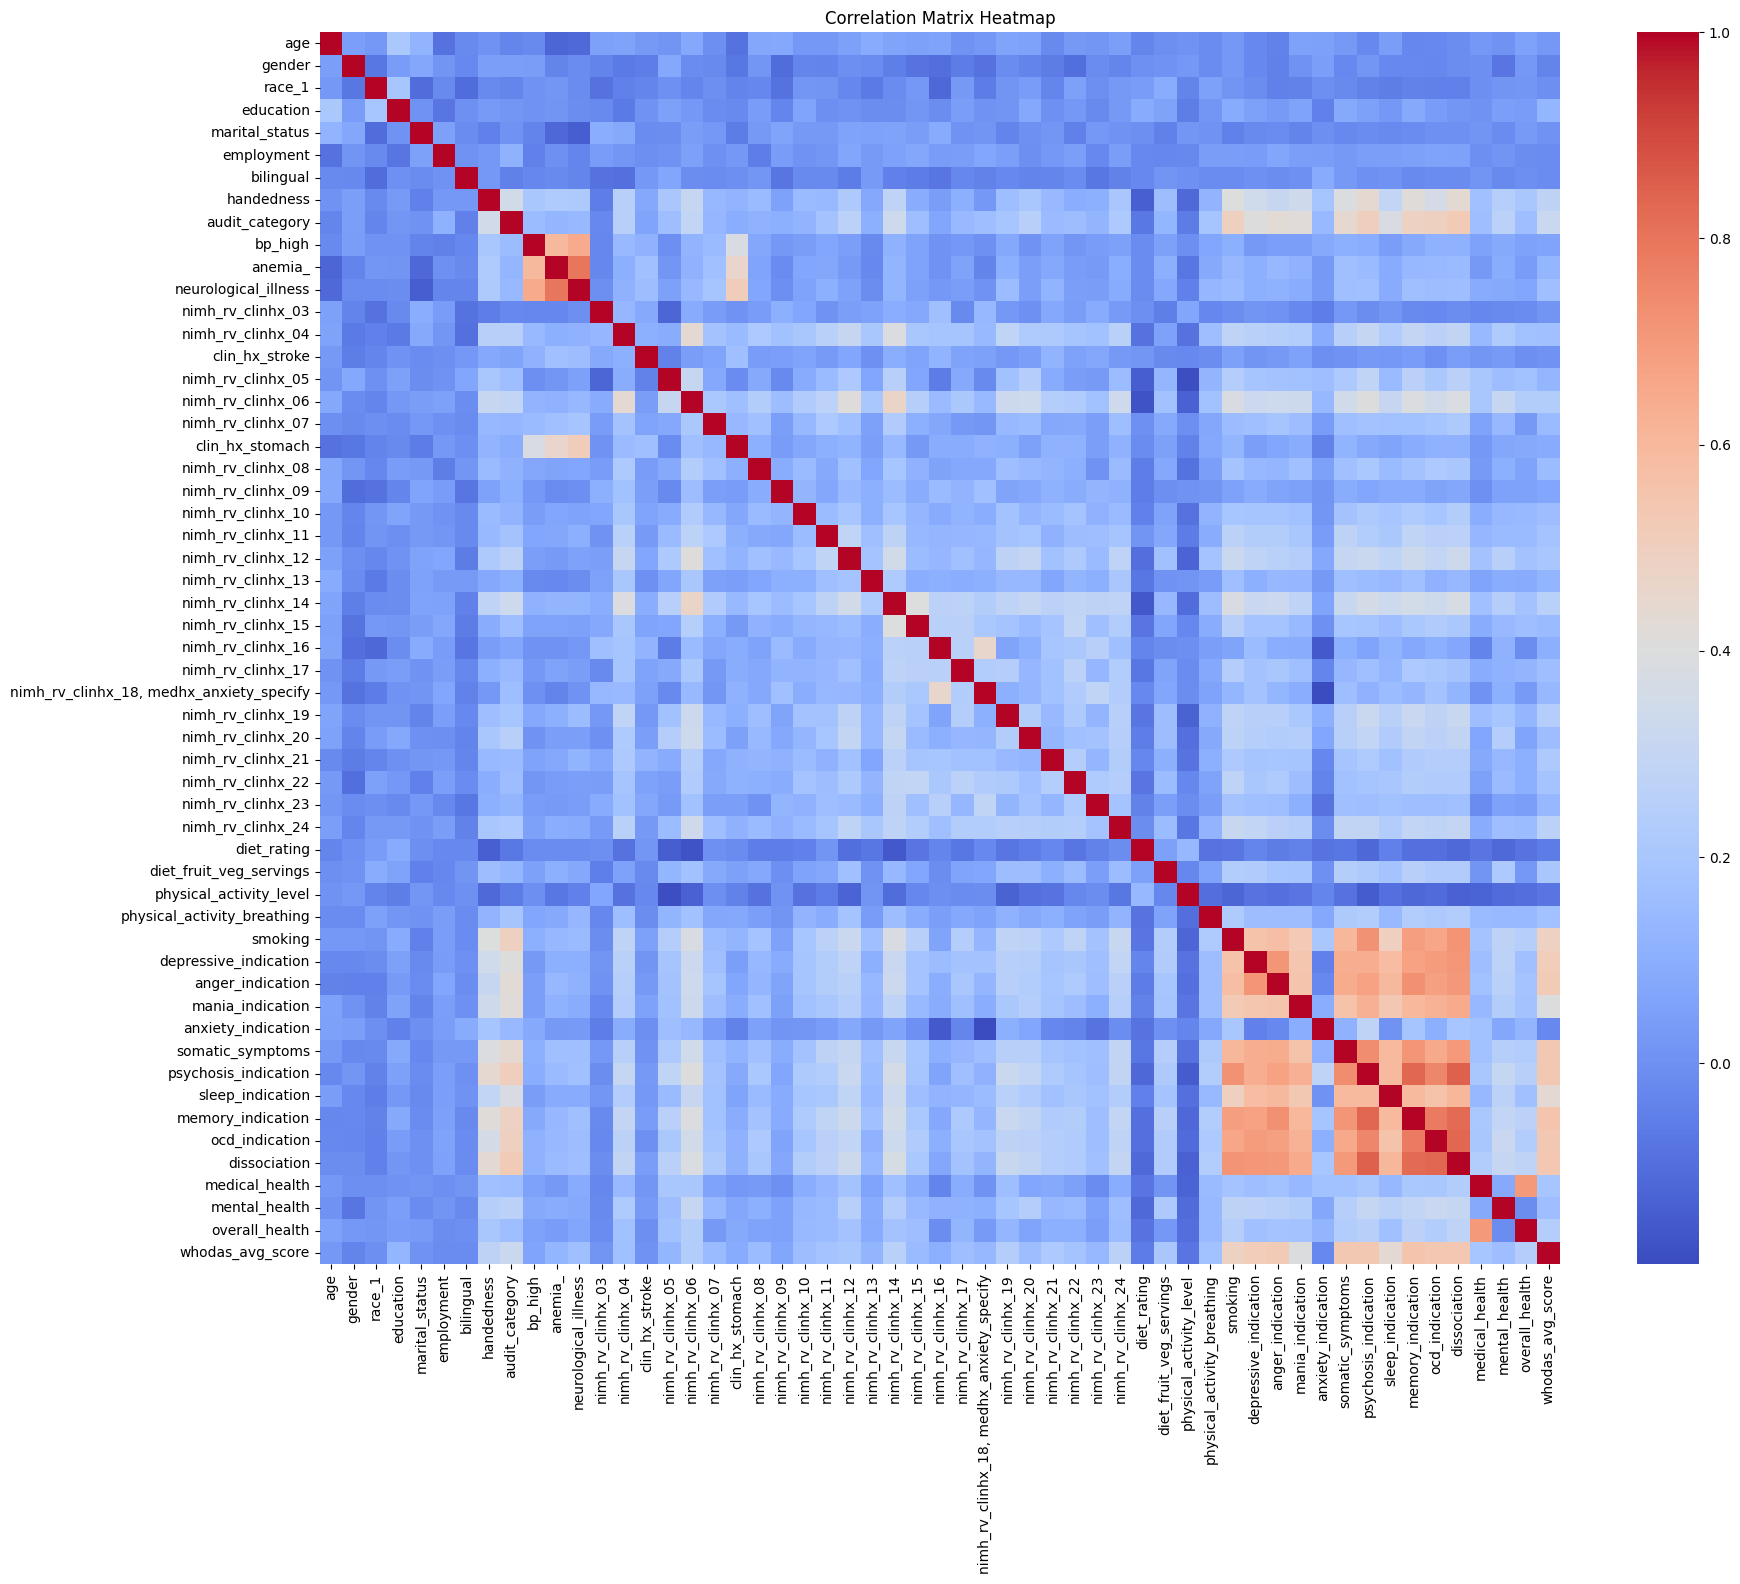

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

encoded_df = pre_dataset.copy()
columns_to_encode = encoded_df.columns.difference(['participant_id'])

category_mappings = {}
for column in columns_to_encode:
    if encoded_df[column].dtype == 'object':  # Check if the column is of type object (categorical)
        unique_categories = encoded_df[column].unique()
        category_mapping = {category: idx for idx, category in enumerate(unique_categories)}
        category_mappings[column] = category_mapping
        encoded_df[column] = encoded_df[column].map(category_mapping)

encoded_df_no_id = encoded_df.drop(columns=['participant_id'])

correlation_matrix = encoded_df_no_id.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, xticklabels=True, yticklabels=True)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=90)
plt.show()

#### ______________________________________________________________________________________________________________________

### Checking anonymity (run time to high for all sensitive attributes at once), divide them up.  

NOTE: After running we see that even after 1.st round generalisation it is not sufficient to reach k-anonymity. 

In [12]:
na_percentages = pre_dataset.isna().mean() * 100

from pycanon import anonymity, report

QI = ['AGE', 'GENDER', 'RACE_1', 'EDUCATION', 'MARITAL_STATUS', 'EMPLOYMENT', 'BILINGUAL', 'handedness']

SA = ['Audit_Category']


#    'nimh_rv_clinhx_07', 'CLIN_HX_STOMACH', 'nimh_rv_clinhx_08', 'nimh_rv_clinhx_09', 'nimh_rv_clinhx_10', 
#    'nimh_rv_clinhx_11', 'nimh_rv_clinhx_12', 'nimh_rv_clinhx_13', 'nimh_rv_clinhx_14', 'nimh_rv_clinhx_15', 
#    'nimh_rv_clinhx_16', 'nimh_rv_clinhx_17', 'nimh_rv_clinhx_18, medhx_anxiety_specify', 'nimh_rv_clinhx_19', 
#    'nimh_rv_clinhx_20', 'nimh_rv_clinhx_21', 'nimh_rv_clinhx_22', 'nimh_rv_clinhx_23', 'nimh_rv_clinhx_24', 
#    'DIET_RATING', 'DIET_FRUIT_VEG_SERVINGS', 'PHYSICAL_ACTIVITY_LEVEL', 'PHYSICAL_ACTIVITY_BREATHING', 'smoking', 
#    'depressive_indication', 'anger_indication', 'mania_indication', 'anxiety_indication', 'somatic_symptoms', 
#    'psychosis_indication', 'sleep_indication', 'memory_indication', 'ocd_indication', 'dissociation', 'MEDICAL_HEALTH', 
#    'MENTAL_HEALTH', 'OVERALL_HEALTH', 'whodas_avg_score']

DATA = pre_dataset

for col in DATA.columns:
    if col in QI + SA: 
        DATA[col] = DATA[col].astype(str)

# Calculate k for k-anonymity:
k = anonymity.k_anonymity(DATA, QI)

# Print the anonymity report:
report.print_report(DATA, QI, SA)

c for (c,l)-diversity cannot be calculated as l=1
The dataset verifies:
          	 - k-anonymity with k = 1
          	 - (alpha,k)-anonymity with alpha = 1.0 and k = 1
          	 - l-diversity with l = 1
          	 - entropy l-diversity with l = 1
          	 - (c,l)-diversity with c = nan and l = 1
          	 - basic beta-likeness with beta = 48.54545454545454
          	 - enhanced beta-likeness with beta = 3.9028905218648733
          	 - t-closeness with t = 0.9798165137614678
          	 - delta-disclosure privacy with delta = 3.9028905218648733


#### ___________________________________________________________________________________________________________________
### Feature extractor to see which columns contributes the most to a low K-anonymity

In [13]:
def find_lowest_unique_columns(data, columns):
    results = []
    initial_unique_rows = data.drop_duplicates(subset=columns).shape[0]
    print(f"Number of unique rows with all columns: {initial_unique_rows}\n")
    
    for column in columns:
        remaining_columns = [col for col in columns if col != column]
        unique_rows = data.drop_duplicates(subset=remaining_columns).shape[0]
        results.append((column, unique_rows))

    results.sort(key=lambda x: x[1], reverse=False)  
    return results

QI = ['AGE', 'GENDER', 'RACE_1', 'EDUCATION', 'MARITAL_STATUS', 'EMPLOYMENT', 'BILINGUAL', 'handedness']
column_results = find_lowest_unique_columns(pre_dataset, QI)

for column, unique_rows_after_removal in column_results:
    print(f"The best column to remove is: {column}")
    print(f"Unique rows after removing {column}: {unique_rows_after_removal}")
    print()

Number of unique rows with all columns: 299

The best column to remove is: RACE_1
Unique rows after removing RACE_1: 185

The best column to remove is: AGE
Unique rows after removing AGE: 186

The best column to remove is: handedness
Unique rows after removing handedness: 205

The best column to remove is: GENDER
Unique rows after removing GENDER: 217

The best column to remove is: MARITAL_STATUS
Unique rows after removing MARITAL_STATUS: 221

The best column to remove is: BILINGUAL
Unique rows after removing BILINGUAL: 225

The best column to remove is: EMPLOYMENT
Unique rows after removing EMPLOYMENT: 228

The best column to remove is: EDUCATION
Unique rows after removing EDUCATION: 274



#### ________________________________________________________________________________________________________________________

### Using Anjana  for K-Anonymity Implementation
###### https://github.com/IFCA-Advanced-Computing/anjana/blob/main/examples/hierarchies/education.csv

In [15]:
pre_dataset = pre_dataset.astype(str)
pre_dataset.columns = [col.lower() for col in pre_dataset.columns]
QI = ['age', 'gender', 'race_1', 'education', 'marital_status', 'employment', 'bilingual', 'handedness']

def create_hierarchies(data, columns):
    for column in columns:
        all_values = data[column].values
        df_values = pd.DataFrame({
            column: all_values,
            'Marker': ['*'] * len(all_values)
        })
        
        # Save to CSV file without index and header
        df_values.to_csv(f'{column}.csv', index=False, header=False)

create_hierarchies(pre_dataset, QI)
new_column_order = ['participant_id'] + QI + [col for col in pre_dataset.columns if col not in QI + ['participant_id']]
pre_dataset = pre_dataset[new_column_order]

### IMPORTANT: In case the algorithm can't reach k = (int) it return a fault in the code, asking to remove a whole column. Beneath both Race and Gedeer had to be removed to satisfy l = 2

In [89]:
from anjana.anonymity import k_anonymity, l_diversity, t_closeness, delta_disclosure


import time
import pycanon



hierarchies = {
    "age": dict(pd.read_csv("age.csv", header=None)),
    "gender": dict(pd.read_csv("gender.csv", header=None)),
    "race_1": dict(pd.read_csv("race_1.csv", header=None)),
    "education": dict(pd.read_csv("education.csv", header=None)),
    "marital_status": dict(pd.read_csv("marital_status.csv", header=None)),
    "employment": dict(pd.read_csv("employment.csv", header=None)),
    "bilingual": dict(pd.read_csv("bilingual.csv", header=None)),
    "handedness": dict(pd.read_csv("handedness.csv", header=None)),
}
#quasi_ident = ['age', 'gender', 'race_1', 'education', 'marital_status', 'employment', 'bilingual', 'handedness']
quasi_ident = ['age','education','marital_status','employment', 'bilingual','gender']
ident =  ['dissociation']

#change as needed 
sens_attr = 'race_1'

k = 15
l_div = 2
alpha = 1
supp_level = 60
delta = 5

t = 0.5

start = time.time()
data_anon = k_anonymity(pre_dataset, ident, quasi_ident, k, supp_level, hierarchies)

#data_anon = l_diversity(
#    data_anon, ident, quasi_ident, sens_attr, k, l_div, supp_level, hierarchies)
end = time.time()


print(f"Elapsed time: {end-start}")
print(f"Value of k calculated: {pycanon.anonymity.k_anonymity(data_anon, quasi_ident)}")
print(
    f"Value of l-diversity: "
    f"\t{pycanon.anonymity.l_diversity(data_anon, quasi_ident, [sens_attr])}"
)
print(
    f"Value of t-closeness: "
    f"\t{pycanon.anonymity.t_closeness(data_anon, quasi_ident, [sens_attr])}"
)

print(f"Number of records suppressed: {len(pre_dataset) - len(data_anon)}")
print(f"Percentage of records suppressed: {100 * (len(pre_dataset) - len(data_anon)) / len(pre_dataset)} %")
print('\n')
data_anon_ids = set(data_anon['participant_id'])
rows_not_in_data_anon = pre_dataset[~pre_dataset['participant_id'].isin(data_anon_ids)]
#rows_not_in_data_anon
pre_dataset['marital_status'].value_counts()
data_anon[0:5]

Elapsed time: 0.027383089065551758
Value of k calculated: 15
Value of l-diversity: 	2
Value of t-closeness: 	0.3486678041737761
Number of records suppressed: 288
Percentage of records suppressed: 26.422018348623855 %




,index,participant_id,age,gender,race_1,education,marital_status,employment,bilingual,handedness,...,somatic_symptoms,psychosis_indication,sleep_indication,memory_indication,ocd_indication,dissociation,medical_health,mental_health,overall_health,whodas_avg_score
0,0,sub-ON00041,20-40,2.0,2.0,higher education,single,unemployed,0,right,...,0.0,0.0,0.0,0.0,0.0,*,fair,poor,fair,none
1,2,sub-ON00541,20-40,2.0,6.0,higher education,single,working,0,right,...,0.0,0.0,1.0,0.0,0.0,*,good,fair,good,none
2,4,sub-ON00641,20-40,2.0,2.0,higher education,single,unemployed,1,right,...,0.0,0.0,0.0,0.0,0.0,*,good,good,good,none
3,5,sub-ON00740,20-40,2.0,5.0,higher education,single,working,0,right,...,0.0,0.0,0.0,0.0,0.0,*,good,good,good,none
4,7,sub-ON00831,40-60,2.0,4.0,higher education,in relationship,working,0,right,...,0.0,0.0,0.0,0.0,0.0,*,good,good,good,none


#### ___________________________________________________________________________________________________________________

#### In house biological measurements. All measurement are flunctuating hence data privacy is not of relevance. 

#### Test BIDS TSV Name
###### Acute Care Panel	acute_care.tsv
###### Blood Chemistry	blood_chemistry.tsv
###### Complete Blood Count with Differential	cbc_with_differential.tsv
###### Hematology Panel	hematology.tsv
###### Hepatic Function Panel	hepatic.tsv
###### Infectious Disease Panel	infectious_disease.tsv
###### Lipid Panel	lipid.tsv
###### Other Panel	other.tsv
###### Urinalysis	urinalysis.tsv
###### Urine Chemistry	urine_chemistry.tsv
###### Vitamin Levels	vitamin_levels.tsv


#### ___________________________________________________________________________________________________________________


### 2. On-Campus In-Person Screening Visit

#### Survey	BIDS TSV Name
###### Adverse Childhood Experiences (ACEs)	ace.tsv
###### Beck Anxiety Inventory (BAI)	bai.tsv
###### Beck Depression Inventory-II (BDI-II)	bdi.tsv
###### Clinical Variable Form	clinical_variable_form.tsv
###### Family Interview for Genetic Studies (FIGS)	figs.tsv
###### Kaufman Brief Intelligence Test 2nd Edition (KBIT-2) and Vocabulary Assessment Scale (VAS)	kbit2_vas.tsv
###### NIH Toolbox Cognition Battery	nih_toolbox.tsv
###### Perceived Health Rating	perceived_health_rating.tsv
###### Satisfaction Survey	satisfaction.tsv
###### Structured Clinical Interview for DSM-5 Disorders (SCID-5)	scid5.tsv

In [23]:
# We can combine the ace score to give numerical value. Aggreagating values will keep a potential adversary from knowing exact information
ace = pd.read_csv('ace.tsv', sep='\t')

# Beck Anxiety Inventory (BAI) consists of 21 self-reported items (four-point scale) used to assess the intensity
# of physical and cognitive anxiety symptoms  during the past week. Scores may range from 0 to 63: minimal anxiety levels 
# (0–7), mild anxiety (8–15), moderate anxiety (16–25), and severe anxiety (26–63).
beck_a = pd.read_csv('bai.tsv', sep='\t')

#Beck Depression Inventory-II (BDI-II)
#Total score of 0-13 is considered minimal range, 14-19 is mild, 20-28 is moderate, and 29-63 is severe.
beck_d = pd.read_csv('bdi.tsv', sep='\t')


clinical_variable_form.tsv